In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

# Using nltk to preprocess text
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Using Tensorflow to build the neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from tensorflow.keras.metrics import Metric
from sklearn.metrics import classification_report

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Loading dataset
# Dataset contains Tweets each classfified as hate-speech, offensive language, or neither
df = pd.read_csv('tweets.csv')
pd.set_option('max_colwidth', 400)
df

In [ ]:
# Dropping columns that aren't needed. Only two we need are class
# (0 - hate speech, 1 - offensive language, 2 - neither) and the text of the tweet
df.columns
df.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], inplace=True)
df.head()

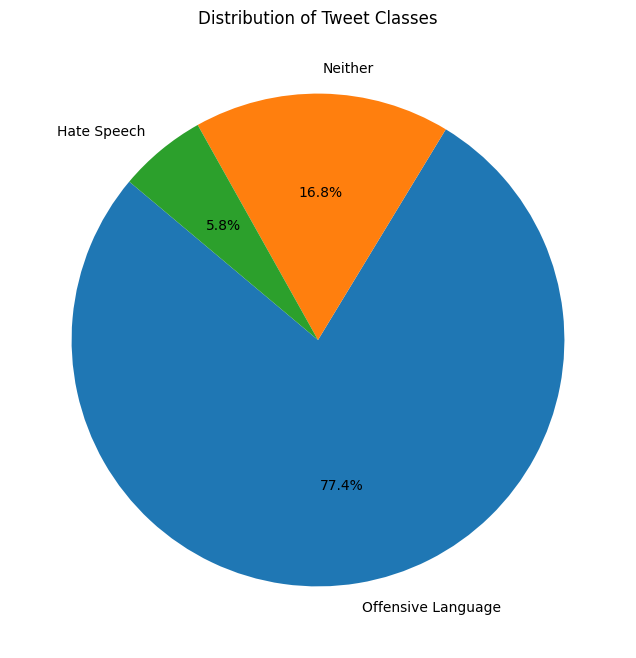

In [ ]:
# Creating a pie chart for the distribution of tweet classifications

# Figuring out how many tweets of each class there are
class_counts = df['class'].value_counts()
labels = ['Offensive Language', 'Neither', 'Hate Speech']

# Using plt to create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Tweet Classes')
plt.show()

In [ ]:
'''
Text pre-processing step 0 - Reverting html special characters to actual symbol and removing retweet
By visually analyzing the data, we can see that some html special characters (eg. &amp)
weren't rendered properly to their actual symbol, so we must deal with that.
We can also see that the retweet mentions were included (eg. RT @user), we don't want that.
'''

import html
import re

# The unescape function reverts text like "&amp" to original symbol "&"
def unescape_html(text):
    return html.unescape(text)
df['tweet'] = df['tweet'].apply(unescape_html)

# The sub function checks the regex applied (checking for the "RT @user" pattern) and replaces it with nothing
def remove_retweet(text):
    return re.sub(r'rt @[A-Za-z0-9_]+', '', text, flags=re.IGNORECASE)
df['tweet'] = df['tweet'].apply(remove_retweet)

In [ ]:
# Text pre-processing step 1 - Removing punctuations from the text

# Convert all tweet text to lowercase for uniformity
df['tweet'] = df['tweet'].str.lower()

# Function to remove punctuation from text
def remove_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# Apply the function to each tweet
df['tweet'] = df['tweet'].apply(remove_punctuations)

In [ ]:
# Text pre-processing step 2 - Removing stop words (eg. the, a, an, in) and lemmatizing
# Lemmatizing a word is reducing a word back to its lemma (eg. builds and building to build)

# Loading the stopwords list and lemmatizer from the nltk library
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# This function splits the text into words, removes stopwords, and lemmatizes the remaining words
def process(text):
    imp_words = [lemmatizer.lemmatize(word) for word in str(text).split() if word not in stop_words]
    return " ".join(imp_words)

# Apply the function to the tweet column and display the DataFrame
df['tweet'] = df['tweet'].apply(process)

In [ ]:
df

In [ ]:
# Function for generating a wordcloud
def generate_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize = 23)
    plt.axis('off')
    plt.show()

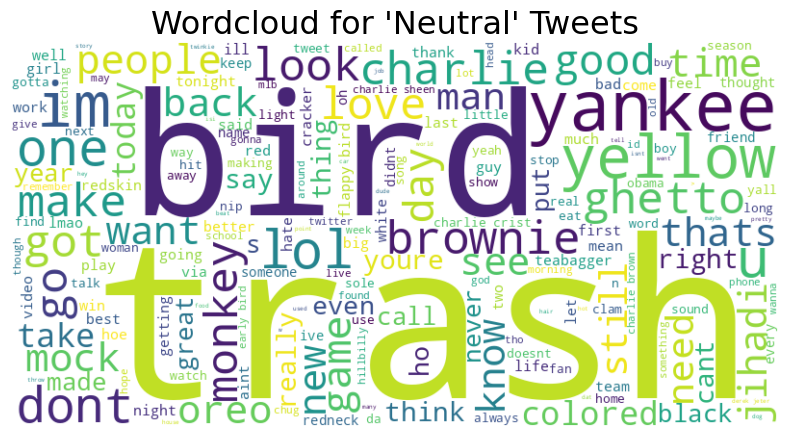

In [ ]:
'''
Creating word cloud for tweets that are neither hate speech or offensive language.
Changing the class number (change 2 to 0 for hate speech or 1 for offensive below)
Creates a word cloud for the tweets from those classes - VIEW WITH CAUTION
'''

neutral_tweets = df[df['class'] == 2]['tweet']
generate_wordcloud(neutral_tweets, "Wordcloud for \'Neutral\' Tweets")

In [ ]:
'''
The dataset is unbalanced, with most tweets (77 percent) being classified as offensive speech
This is going to affect the performance of our model, as it may develop a bias towards
the majority class (offensive speech). To combat this, we will downsample the offensive
speech class to 4200 entries and upsample (by 3 times) the hate speech class.
'''

neither = df[df['class'] == 2]
#offensive = df[df['class'] == 1].sample(n=4200)
offensive = df[df['class'] == 1]
hate = df[df['class'] == 0]

balanced_df = pd.concat([hate, hate, hate, hate, hate, offensive, neither, neither], axis=0)

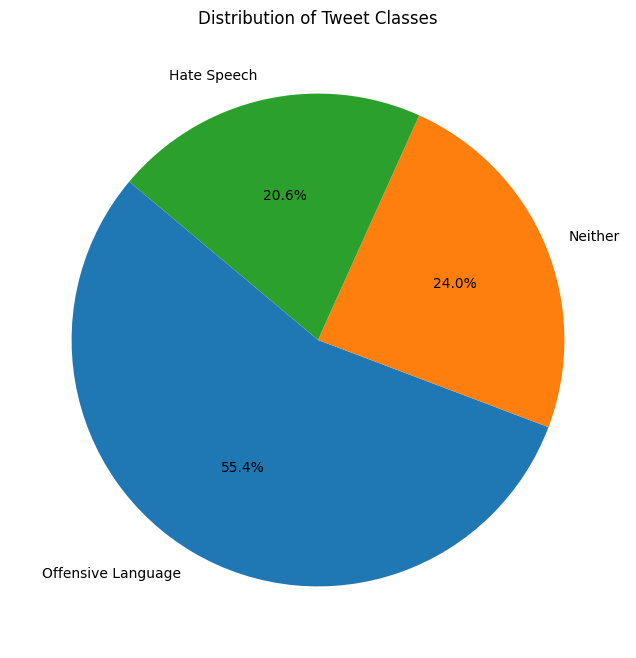

In [ ]:
# Pie chart will be more evenly distributed now

class_counts = balanced_df['class'].value_counts()
labels = ['Offensive Language', 'Neither', 'Hate Speech']

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Tweet Classes')
plt.show()

In [ ]:
# Splitting dataset into training and testing

X = balanced_df['tweet'] 
y = balanced_df['class'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# One-hot encode the target variable
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

y_train

In [ ]:
# Tokenizing the text

tokenizer = Tokenizer(num_words=10000, lower=True, split=' ')

# Fit the tokenizer on the training data. Assigning each word an integer for the model to understand
tokenizer.fit_on_texts(X_train)

# Converting the text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding the sequences to have the same length
max_length = max(max(len(x) for x in X_train_seq), max(len(x) for x in X_test_seq))
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [ ]:
# Model definition

model = keras.models.Sequential([
    layers.Embedding(input_dim=10000, output_dim=32, input_length=max_length),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 24, 32)            320000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 512)               16896     
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                

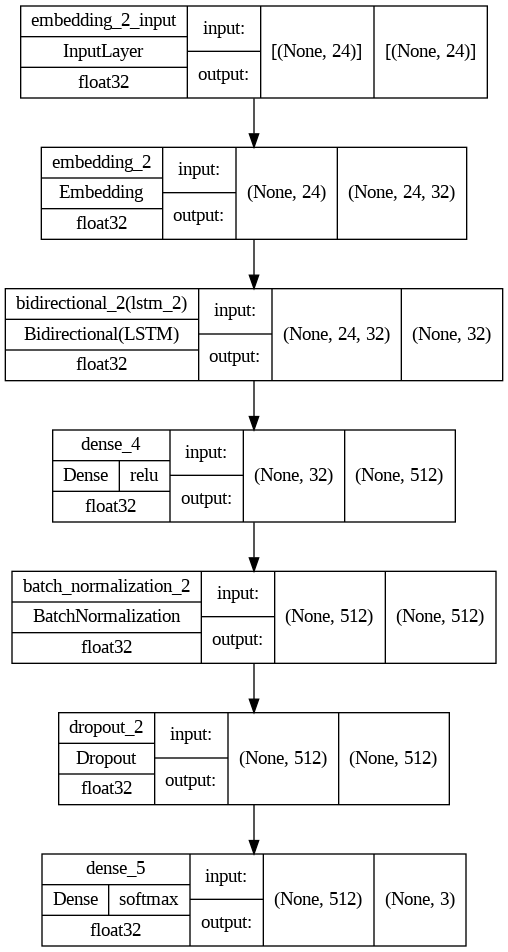

In [ ]:
# graphical representation of our model, showing the configuration of layers,
# their shapes, and how they're connected.
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

In [ ]:
# Defining callback functions to stop training if model isn't improving

# If accuracy doesn't improve after 5 epochs, stop training
stop = keras.callbacks.EarlyStopping(patience=5,
                   monitor = 'val_accuracy',
                   restore_best_weights = True, verbose=1)

# Reduced the learning rate if the loss has stopped improving after 2 epochs
learn = keras.callbacks.ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.2,
                       verbose = 1)

In [ ]:
history = model.fit(X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=20,
    verbose=1,
    batch_size=32,
    callbacks=[stop, learn]

)

Epoch 1/20
867/867 [==============================] - 28s 27ms/step - loss: 0.4232 - accuracy: 0.8465 - f1_m: 0.8351 - precision_m: 0.8618 - recall_m: 0.8175 - val_loss: 0.2741 - val_accuracy: 0.9021 - val_f1_m: 0.9012 - val_precision_m: 0.9044 - val_recall_m: 0.8981 - lr: 0.0010
Epoch 2/20
867/867 [==============================] - 22s 26ms/step - loss: 0.1788 - accuracy: 0.9374 - f1_m: 0.9375 - precision_m: 0.9399 - recall_m: 0.9352 - val_loss: 0.3528 - val_accuracy: 0.8800 - val_f1_m: 0.8797 - val_precision_m: 0.8818 - val_recall_m: 0.8776 - lr: 0.0010
Epoch 3/20
867/867 [==============================] - 21s 25ms/step - loss: 0.1168 - accuracy: 0.9624 - f1_m: 0.9621 - precision_m: 0.9630 - recall_m: 0.9613 - val_loss: 0.2616 - val_accuracy: 0.9087 - val_f1_m: 0.9082 - val_precision_m: 0.9091 - val_recall_m: 0.9073 - lr: 0.0010
Epoch 4/20
867/867 [==============================] - 24s 28ms/step - loss: 0.0919 - accuracy: 0.9698 - f1_m: 0.9697 - precision_m: 0.9701 - recall_m: 0.9694

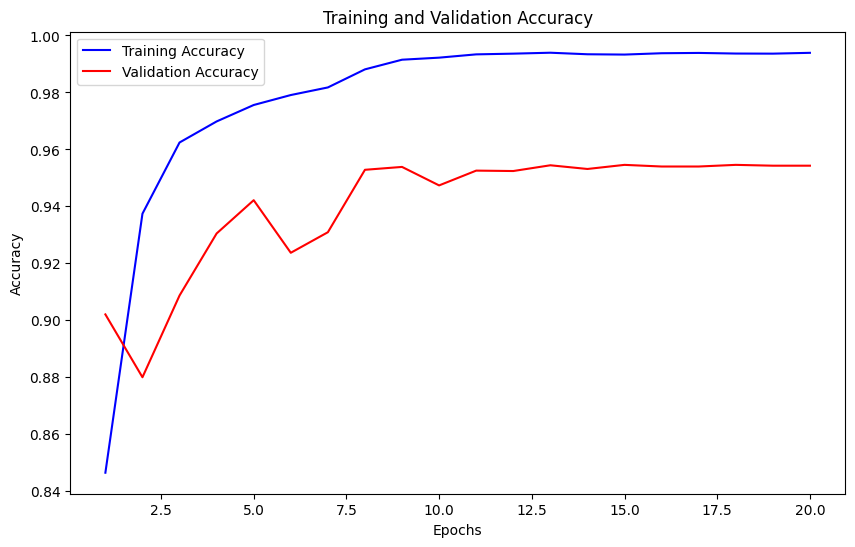

In [ ]:
# Plot training and validation accuracy

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

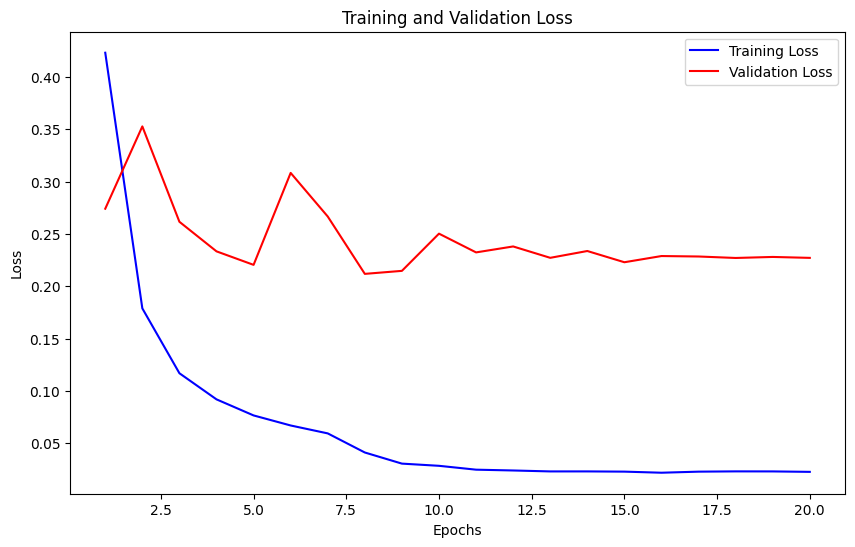

In [ ]:
# Plot training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy, f1_score, precision, recall = model.evaluate(X_test_pad, y_test)

print("Accuracy on test data:", test_accuracy)
print("F1 Score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)

y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
report = classification_report(y_true_classes, y_pred_classes, target_names=['Hate Speech', 'Offensive Language', 'Neither'])
print(report)

# Per-class accuracy
per_class_accuracy = {}
for i, class_name in enumerate(['Hate Speech', 'Offensive Language', 'Neither']):
    class_mask = (y_true_classes == i)
    class_correct = (y_true_classes[class_mask] == y_pred_classes[class_mask]).sum()
    class_total = class_mask.sum()
    per_class_accuracy[class_name] = class_correct / class_total

print("\nPer-Class Accuracy:")
for class_name, accuracy in per_class_accuracy.items():
    print(f"{class_name}: {accuracy:.4f}")

217/217 [==============================] - 2s 7ms/step - loss: 0.2229 - accuracy: 0.9546 - f1_m: 0.9547 - precision_m: 0.9549 - recall_m: 0.9545
Accuracy on test data: 0.9545716643333435
F1 Score: 0.9547010660171509
Precision: 0.9549158215522766
Recall: 0.9544931054115295
                    precision    recall  f1-score   support

       Hate Speech       0.92      0.99      0.95      1435
Offensive Language       0.98      0.94      0.96      3813
           Neither       0.94      0.95      0.95      1686

          accuracy                           0.95      6934
         macro avg       0.95      0.96      0.95      6934
      weighted avg       0.96      0.95      0.95      6934


Per-Class Accuracy:
Hate Speech: 0.9895
Offensive Language: 0.9420
Neither: 0.9531


In [ ]:
text = "you are bad"

text_seq = tokenizer.texts_to_sequences([text])
text_pad = pad_sequences(text_seq, maxlen=24)

In [ ]:
model.predict(text_pad)

array([[2.5964013e-04, 4.6002439e-01, 5.3971589e-01]], dtype=float32)

In [ ]:
# Calculating the score (weighted average) of the prediction
def calculate_score(prediction):
    # 100 multiplier for hate speech, 50 multiplier for offensive speech, 0 multiplier for neither
    multipliers = [100, 50, 0]
    score = np.dot(prediction, multipliers)
    return round(score, 2)

# Classifying the text based on score
def classify_text(score):
    if 80 <= score <= 100:
        return 'Hate Speech'
    elif 60 <= score < 80:
        return 'Very Offensive Language/Leaning Towards Hate Speech'
    elif 40 <= score < 60:
        return 'Offensive Language'
    elif 20 <= score < 40:
        return 'Leaning Towards Offensive Language'
    elif 0 <= score < 20:
        return 'Not Offensive or Hate Speech'
    else:
        return 'Unknown Category'

prediction = model.predict(text_pad)

# Calculate score for the input text
score = calculate_score(prediction[0])
category = classify_text(score)

print("Score for the input text:", score)
print("Category of the text:", category)

Score for the input text: 23.03
Category of the text: Leaning Towards Offensive Language


In [ ]:
# Saving the tokenizer to use in our app
'''
from google.colab import drive
import os
import json
drive.mount('/content/drive')
base_path = '/content/drive/My Drive'


tokenizer_path = os.path.join(base_path, 'tokenizer-2.json')
tokenizer_json = tokenizer.to_json()
with open(tokenizer_path, 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))


Mounted at /content/drive


In [ ]:
# Saving the model to use in our app
'''
model.save('/content/drive/MyDrive/model-2.h5')